In [1]:
import os
import numpy as np
import gym
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.callbacks import BaseCallback
from fmi_mlc import fmi_gym
from config import parameter as PARAMS

# ————————————————————————————————————————
# Preparar carpetas
# ————————————————————————————————————————
os.makedirs("logs", exist_ok=True)
os.makedirs("models", exist_ok=True)

# ————————————————————————————————————————
# Callback: registrar recompensa real paso a paso
# ————————————————————————————————————————
class StepRewardLogger(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.raw_rewards = []
        self.timesteps   = []

    def _on_step(self) -> bool:
        info = self.locals["infos"][0]
        raw_r = float(info.get("raw_reward", 0.0))
        self.raw_rewards.append(raw_r)
        self.timesteps.append(self.num_timesteps)
        return True

    def _on_training_end(self) -> None:
        np.savez(
            "logs/step_rewards_real.npz",
            timesteps   = np.array(self.timesteps,   dtype=np.int32),
            raw_rewards = np.array(self.raw_rewards, dtype=np.float32)
        )

# ————————————————————————————————————————
# Wrapper: recompensa real = –sum(|PMV|)
# ————————————————————————————————————————
class PmvEnv(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)

    def step(self, action):
        obs, _, done, info = self.env.step(action)
        last = self.env.data.iloc[-1]
        pmvs = np.array([last[r] for r in PARAMS["reward_names"]], dtype=np.float32)
        real_reward = - np.abs(pmvs).sum()
        info = info.copy()
        info["raw_reward"] = real_reward
        return obs, real_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

# ————————————————————————————————————————
# Función para crear el entorno
# ————————————————————————————————————————
def make_env():
    base = fmi_gym(PARAMS)
    return PmvEnv(base)

# ————————————————————————————————————————
# Construcción de VecNormalize + SAC + entrenamiento
# ————————————————————————————————————————
vec_env = DummyVecEnv([make_env])
env     = VecNormalize(
    vec_env,
    norm_obs=True,
    norm_reward=True,
    clip_obs=10.0
)

callback = StepRewardLogger()

model = SAC(
    policy="MlpPolicy",
    env=env,
    learning_rate=1e-5,
    buffer_size=500_000,
    batch_size=16,
    tau=0.0001,
    ent_coef=0.0001,
    verbose=1
)

TOTAL_TIMESTEPS = 100_000
model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=callback)

/opt/conda/envs/simulation/lib/python3.9/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device


[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 18316800.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 50651.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 50651.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 3.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 7.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmptg5u09g5//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmptg5u09g5//resources//Res_flat1.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 2
This is the End Month: 7
This is the Day of the End Month: 31
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.013
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.17 14:09
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculati

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 18316800.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 47211.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 47211.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpgfh_co_n//resources//Res_flat1.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 2
This is the End Month: 7
This is the Day of the End Month: 31
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.014
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.17 14:10
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculati

[FMU status:OK] done searching pattern .idf

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpgfh_co_n//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .epw

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file weather.epw.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .epw

[INFO][Slave] [ok][FMU status:OK] Get input file from resource fold

Updating Shadowing Calculations, Start Date=07/22/2002
Updating Detailed Daylighting Factors, Start Date=07/22
Continuing Simulation at 07/22/2002 for SENZA TITOLO (01-01:31-12)


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.07sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.04sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 47.82sec
Reading input and weather file for preprocessor program.


[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 18316800.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 50107.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 50107.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 3.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 7.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpggxszibu//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory

The IDF version of the input file ///tmp/JModelica.org/jm_tmpggxszibu//resources//Res_flat1.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 2
This is the End Month: 7
This is the Day of the End Month: 31
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.013
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.17 14:11
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and En

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 18316800.000000 which is provided.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.07sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.04sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 47.25sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp24hm3fwk//resources//Res_flat1.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 2
This is the End Month: 7
This is the Day of the End Month: 31
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.014
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.17 14:12
Initializing Response F

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 44353.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 44353.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 3.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 7.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp24hm3fwk//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file Res_flat1.idf.

[INFO][Slave] [ok]

rming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #5 WINTER DESIGN DAY IN SENZA TITOLO (01-01:31-12)
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Instantiating FunctionalMockupUnitExport interface
ExternalInterface initializes.
Number of outputs in ExternalInterface = 7
Number of inputs  in ExternalInterface = 3
Calculating Detailed Daylighting Factors, Start Date=07/02
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 07/02/2002 for SENZA TITOLO (01-01:31-12)
ExternalInterface starts first data exchange.
Updating Shadowing Calculations, Start Date=07/22/2002
Updating Detailed Daylighting Factors, Start Date=07/22
Continuing Simulation at 07/22/2002 for SENZA TITOLO (01-01:31-12)


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 18316800.000000 which is provided.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.07sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.05sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 47.68sec
Reading input and weather file for preprocessor program.
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 77       |
|    time_elapsed    | 224      |
|    total_timesteps | 17280    |
| train/             |          |
|    actor_loss      | 0.0469   |
|    critic_loss     | 0.00026  |
|    ent_coef        | 0.0001   |
|    learning_rate   | 1e-05    |
|    n_updates       | 17179    |
---------------------------------
The IDF version of the input file ///tmp/JModelica.org/jm_tmp73s62ly1//resources//Res_flat1.idf starts with 9
Successfully

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 42683.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 42683.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 3.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 7.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp73s62ly1//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file Res_flat1.idf.

[INFO][Slave] [ok]

Updating Shadowing Calculations, Start Date=07/22/2002
Updating Detailed Daylighting Factors, Start Date=07/22
Continuing Simulation at 07/22/2002 for SENZA TITOLO (01-01:31-12)


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.07sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.04sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 47.48sec


[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 18316800.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 44705.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 44705.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 3.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 7.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpycborg_7//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpycborg_7//resources//Res_flat1.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 2
This is the End Month: 7
This is the Day of the End Month: 31
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.013
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.17 14:14
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculati

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.07sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.04sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 47.81sec
Reading input and weather file for preprocessor program.


[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 18316800.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 43365.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 43365.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 3.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 7.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp_z7__fsl//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory

The IDF version of the input file ///tmp/JModelica.org/jm_tmp_z7__fsl//resources//Res_flat1.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 2
This is the End Month: 7
This is the Day of the End Month: 31
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.012
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.17 14:15
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and En

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.05sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 48.98sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp_gk0uywx//resources//Res_flat1.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 2
This is the End Month: 7
This is the Day of the End Month: 31
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.013
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.17 14:16
Initializing Response F

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 18316800.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 57225.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 57225.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 3.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 7.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp_gk0uywx//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory

Number of outputs in ExternalInterface = 7
Number of inputs  in ExternalInterface = 3
Calculating Detailed Daylighting Factors, Start Date=07/02
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 07/02/2002 for SENZA TITOLO (01-01:31-12)
ExternalInterface starts first data exchange.
Updating Shadowing Calculations, Start Date=07/22/2002
Updating Detailed Daylighting Factors, Start Date=07/22
Continuing Simulation at 07/22/2002 for SENZA TITOLO (01-01:31-12)
Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.07sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.04sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 47.31sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 18316800.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 35421.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 35421.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpwko_st65//resources//Res_flat1.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 2
This is the End Month: 7
This is the Day of the End Month: 31
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.014
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.17 14:17
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculati

er ///tmp/JModelica.org/jm_tmpwko_st65//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idd

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file Energy+.idd.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idd

[INFO][Slave] [ok][FMU status:OK] This version uses the **energyplus** command line interface to  call the EnergyPlus executable. **RunEPlus.bat** and **runenergyplus** , which were used in earlier versions, were deprecated as of August 2015.
Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider se

Updating Shadowing Calculations, Start Date=07/22/2002
Updating Detailed Daylighting Factors, Start Date=07/22
Continuing Simulation at 07/22/2002 for SENZA TITOLO (01-01:31-12)


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.07sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.04sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 46.92sec


[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 18316800.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 54749.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 54749.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 3.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 7.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp69bf2pbt//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp69bf2pbt//resources//Res_flat1.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 2
This is the End Month: 7
This is the Day of the End Month: 31
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.013
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.17 14:18
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculati

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 18316800.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 40875.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 40875.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.07sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.04sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 47.69sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpryhiltvt//resources//Res_flat1.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 2
This is the End Month: 7
This is the Day of the End Month: 31
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.013
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.17 14:18
Initializing Response F

er ///tmp/JModelica.org/jm_tmpryhiltvt//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idd

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file Energy+.idd.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idd

[INFO][Slave] [ok][FMU status:OK] This version uses the **energyplus** command line interface to  call the EnergyPlus executable. **RunEPlus.bat** and **runenergyplus** , which were used in earlier versions, were deprecated as of August 2015.
Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider se

Updating Shadowing Calculations, Start Date=07/22/2002
Updating Detailed Daylighting Factors, Start Date=07/22
Continuing Simulation at 07/22/2002 for SENZA TITOLO (01-01:31-12)


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.07sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.04sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 50.43sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp7g_k8qpd//resources//Res_flat1.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 2
This is the End Month: 7
This is the Day of the End Month: 31
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.013
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.17 14:19
Initializing Response F

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 18316800.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 36603.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 36603.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 3.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 7.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp7g_k8qpd//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory

arming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) SET
Warming up
Calculating Detailed Daylighting Factors, Start Date=01/15
Warming up
Warming up
Warming up
Warming up
Warming up
Wa

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 18316800.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 55787.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 55787.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpnyt9m16o//resources//Res_flat1.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 2
This is the End Month: 7
This is the Day of the End Month: 31
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.013
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.17 14:20
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculati

[FMU status:OK] done searching pattern .idf

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpnyt9m16o//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .epw

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file weather.epw.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .epw

[INFO][Slave] [ok][FMU status:OK] Get input file from resource fold

Updating Shadowing Calculations, Start Date=07/22/2002
Updating Detailed Daylighting Factors, Start Date=07/22
Continuing Simulation at 07/22/2002 for SENZA TITOLO (01-01:31-12)


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 18316800.000000 which is provided.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.07sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.04sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 48.65sec


[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 39879.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 39879.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 3.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 7.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpg16if3h8//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file Res_flat1.idf.

[INFO][Slave] [ok]

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpg16if3h8//resources//Res_flat1.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 2
This is the End Month: 7
This is the Day of the End Month: 31
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.014
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.17 14:21
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculati

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 18316800.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 56039.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 56039.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Updating Shadowing Calculations, Start Date=07/22/2002
Updating Detailed Daylighting Factors, Start Date=07/22
Continuing Simulation at 07/22/2002 for SENZA TITOLO (01-01:31-12)


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.07sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.04sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 48.72sec
Reading input and weather file for preprocessor program.


[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 18316800.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 58597.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 58597.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 3.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 7.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpsygre2ll//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory

The IDF version of the input file ///tmp/JModelica.org/jm_tmpsygre2ll//resources//Res_flat1.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 2
This is the End Month: 7
This is the Day of the End Month: 31
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.013
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.17 14:23
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and En

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.09sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.04sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 48.20sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpfzf6cq37//resources//Res_flat1.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 2
This is the End Month: 7
This is the Day of the End Month: 31
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.013
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.17 14:24
Initializing Response F

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 18316800.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 43271.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 43271.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 3.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 7.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpfzf6cq37//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory

Updating Shadowing Calculations, Start Date=07/22/2002
Updating Detailed Daylighting Factors, Start Date=07/22
Continuing Simulation at 07/22/2002 for SENZA TITOLO (01-01:31-12)


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.07sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.04sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 46.87sec
Reading input and weather file for preprocessor program.


[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 18316800.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 36003.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 36003.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 3.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 7.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpep43yoek//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory

The IDF version of the input file ///tmp/JModelica.org/jm_tmpep43yoek//resources//Res_flat1.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 2
This is the End Month: 7
This is the Day of the End Month: 31
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.013
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.17 14:25
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and En

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.04sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 48.99sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpwcfd_btx//resources//Res_flat1.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 2
This is the End Month: 7
This is the Day of the End Month: 31
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.014
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.17 14:26
Initializing Response F

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 18316800.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 53271.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 53271.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 3.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 7.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpwcfd_btx//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory

arming up
Performing Zone Sizing Simulation
...for Sizing Period: #1 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) GIU
Warming up
Calculating Detailed Daylighting Factors, Start Date=07/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #2 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) LUG
Warming up
Calculating Detailed Daylighting Factors, Start Date=08/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #3 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) AGO
Warming up
Calculating Detailed Daylighting Factors, Start Date=09/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
...for Sizing Period: #4 SUMMER DESIGN DAY IN SENZA TITOLO (01-01:31-12) SET
Warming up
Calculating Detailed Daylighting Factors, Start Date=01/15
Warming up
Warming up
Warming up
Warming up
Warming up
Wa

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.04sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 48.10sec
Reading input and weather file for preprocessor program.


[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 18316800.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 60007.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 60007.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 3.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 7.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpj03bqv2j//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory

The IDF version of the input file ///tmp/JModelica.org/jm_tmpj03bqv2j//resources//Res_flat1.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 2
This is the End Month: 7
This is the Day of the End Month: 31
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.013
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.17 14:27
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and En

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 18316800.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 42873.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 42873.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.07sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.05sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 48.62sec
Reading input and weather file for preprocessor program.
---------------------------------
| time/              |          |
|    episodes        | 20       |
|    fps             | 78       |
|    time_elapsed    | 1095     |
|    total_timesteps | 86400    |
| train/             |          |
|    actor_loss      | 0.169    |
|    critic_loss     | 0.000321 |
|    ent_coef        | 0.0001   |
|    learning_rate   | 1e-05    |
|    n_updates       | 86299    |
---------------------------------
The IDF version of the input file ///tmp/JModelica.org/jm_tmpscagtv8z//resources//Res_flat1.idf starts with 9
Successfully

[FMU status:OK] done searching pattern .idf

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpscagtv8z//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .epw

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file weather.epw.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .epw

[INFO][Slave] [ok][FMU status:OK] Get input file from resource fold

Updating Shadowing Calculations, Start Date=07/22/2002
Updating Detailed Daylighting Factors, Start Date=07/22
Continuing Simulation at 07/22/2002 for SENZA TITOLO (01-01:31-12)
Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.07sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.04sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 45.63sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmph3jw0dzy//resources//Res_flat1.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 2
This is the End Month: 7
This is the Day of the End Month: 31
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.013
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.17 14:28
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculati

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 18316800.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 46127.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 46127.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 3.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 7.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmph3jw0dzy//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory

Updating Shadowing Calculations, Start Date=07/22/2002
Updating Detailed Daylighting Factors, Start Date=07/22
Continuing Simulation at 07/22/2002 for SENZA TITOLO (01-01:31-12)
Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.07sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.04sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 49.66sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 18316800.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 32941.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 32941.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpf3ome9rw//resources//Res_flat1.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 2
This is the End Month: 7
This is the Day of the End Month: 31
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.013
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.17 14:29
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculati

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.07sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.04sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 00min 47.20sec
Reading input and weather file for preprocessor program.


[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 18316800.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 58251.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 58251.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 3.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 7.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpa9jeybpw//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory

The IDF version of the input file ///tmp/JModelica.org/jm_tmpa9jeybpw//resources//Res_flat1.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 7
This is the Day of the Begin Month: 2
This is the End Month: 7
This is the Day of the End Month: 31
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.013
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.17 14:30
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "_FLATROOF_MOD"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "PAVIMENTO CONTROTERRA DI PROGETTO"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and En

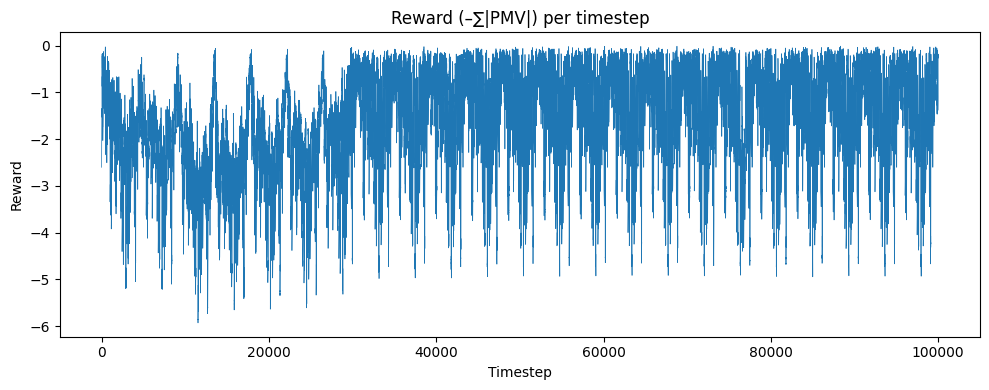

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Cargar datos guardados
data = np.load("logs/step_rewards_real.npz")
timesteps = data["timesteps"]
rewards   = data["raw_rewards"]

# Graficar
plt.figure(figsize=(10,4))
plt.plot(timesteps, rewards, linewidth=0.5)
plt.title("Reward (–∑|PMV|) per timestep")
plt.xlabel("Timestep")
plt.ylabel("Reward")
plt.tight_layout()
plt.show()

In [4]:
model.save('/home/jovyan/controller_notebooks/test2_agent')
env.save('/home/jovyan/controller_notebooks/test2_agent_vecnormalize.plk')